## 第十周: 字詞分類

**Author:** 劉岱宜<br>
**Date created:** 2021/10/01<br>
**Last modified:** 2021/11/17<br>
本周課程為「文件分類」，主要使用文章轉DTM(document term matrix)的方式，將文章用不同的字詞分布表示，再利用python的sklearn套件，套用SVM、linear regression等方式訓練模型，以分辨不同的文件。本篇 Jupyter Notebook 將展示「英文」的文件分類，使用Jane austen的pride and prejudice與H. G. Wells的the war of the worlds做示範。

## 大綱
1. 套件說明
2. 文字前處理
    + 2.1 前處理：斷詞、文字清理（刪掉次數太少的、標點符號、停用字）
    + 2.2 資料集基本檢視
3. 將資料分為測試集和訓練集
    + 3.1 根據7:3的比例切分資料集
4. 將文章轉為 DTM 放入模型訓練
    + 4.1 簡單範例介紹DTM
    + 4.2 套入正式資料集訓練
    + 4.3. 定義建模與畫圖的函數
5. 比較不同模型和資料組合的訓練結果
    + 5.1 logistic regression
    + 5.2 SVC
    + 5.3 decision tree
    + 5.4 預測結果探索
        + 5.4.1 各字詞特徵的estimate係數
        + 5.4.2 查看分類錯誤的句子
        + 5.4.3 比較不同模型的ROC

## 分析目標
分析主題：利用線性模型將　gutenberg 網站的兩本英文小說，Jane austen 的 「pride and prejudice」和H. G. Wells的「the war of the worlds」，轉成字詞向量的方式，進行文件分類，希望分析可以獲得以下資訊：
1. 兩本小說的字詞分部有甚麼不同，代表字詞有哪些？
    +  討論章節：2.2 資料集基本檢視
        + 斷詞、詞性還原後檢視詞頻
    + 討論章節：5.4.1 各字詞特徵的estimate係數
        + 利用建模後的estimate係數挑選各文集代表字
2. 如果用詞頻建立DTM，需不需要篩選詞頻？
    + 討論章節：4.2 套入正式資料集訓練
        + 比較篩詞頻前後的DTM預測效果
3. 此資料集用什麼樣的模型預測，準確率會較高？
    + 討論章節：5.4.3 比較不同模型的ROC
        + 以不同模型的ROC比較準確率

## 1. 套件說明
下面列出在本次實作過程中我們所使用到的相關套件，在這個Jupyter Notebook當中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。
- pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
- NLTK: 全名為Natural Language Tool Kit，自然語言處理工具。
- sklearn: 全名為Scikit-learn，機器學習的常用建模套件，包含各種分群、分類、迴歸模型，如隨機森林、SVM或 K-means 等。
- seaborn: 基於 matplotlib 封裝的繪圖工具
- time: 獲得目前的時間或作時間格式轉換的工具

In [1]:
# 安裝會使用到的套件
# %pip install sklearn seaborn

In [2]:
# 確認當前工作目錄
%pwd

'/home/ann2/social_media/test/week10_classifiaction'

In [3]:
import pandas as pd
import re
import nltk
import string
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn import metrics, model_selection, feature_extraction
from sklearn import feature_extraction, model_selection, naive_bayes,pipeline,\
manifold, preprocessing, feature_selection, metrics, svm, tree, ensemble
from sklearn.linear_model import LogisticRegression

import seaborn as sns
import time

## 2. 文字前處理
`books.csv`裡面已經包含了兩本書的資料，分別用不同的 gutenberg_id 表示，每個row為一個句子，在這裡我們把一個句子視為一個文件(document)，為了後面建立 DTM(document-term-matrix) 我們先清理停用字和詞頻太少的句子，並做基本的文件探索。

In [4]:
books = pd.read_csv("raw_data/books.csv") #匯資料
books.head(3)

,gutenberg_id,text,title,document
0,36,The War of the Worlds,The War of the Worlds,1
1,36,NaN,The War of the Worlds,2
2,36,by H. G. Wells [1898],The War of the Worlds,3


一個句子視為一個document，查看兩本書各有多少個句子，發現兩本書的句子大概差了兩倍

In [5]:
books.title.value_counts()

Pride and Prejudice      13030
The War of the Worlds     6474
Name: title, dtype: int64

### 2.1 文字前處理
+ 進行斷詞
+ 去除stopwords
+ 篩選出現太少次的字

使用nltk套件中預設的英文停用字，也可以加上自訂停用字

In [6]:
nltk.download('stopwords')
user_defined_stop_words = ['st','rd','hong','kong'] 

i = nltk.corpus.stopwords.words('english')
j = list(string.punctuation) + user_defined_stop_words

stopwords = set(i).union(j)

[nltk_data] Downloading package stopwords to /home/ann2/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
def preprocess(x):
    x = re.sub('[^a-z\s]', '', x.lower())   # 去除標點符號
    x = [w for w in x.split() if w not in set(stopwords)]  # 去除停用字
    return x

將斷詞後的結果以上面定義的 `preprocess`去除標點符號、去除停用字
`raw_data` 用來做後面建模的資料，`original`是未處理過的原始句子，

In [8]:
raw_data = books[books['text'].notnull()].reset_index() # 去掉 nan 的 row
original = raw_data # 用來看原本句子長什麼樣的

raw_data['text'] = raw_data['text'].apply(preprocess) # 資料前處理
words = raw_data.explode('text')
words.head(5)

raw_data['text'] = raw_data["text"].str.join(" ") # 從list還原成句子string

去除掉詞頻小於10的字

In [9]:
occur = 10
filtered = words.groupby(['gutenberg_id','text'])['text'].filter(lambda x: len(x) >= occur) # 出現次數大於10的字
words = words[words['text'].isin(filtered)]
words.head(5)

,index,gutenberg_id,text,title,document
0,0,36,war,The War of the Worlds,1
2,5,36,shall,The War of the Worlds,6
4,7,36,world,The War of the Worlds,8
4,7,36,things,The War of the Worlds,8
4,7,36,made,The War of the Worlds,8


### 2.2 資料集基本檢視

看資料集裡面有幾個字

In [10]:
print(f"unique words: {len(words.text.unique())}")

unique words: 1428


套用 nltk 的 `WordNetLemmatizer` 詞性還原，看看減少了幾個字

In [11]:
nltk.download('wordnet')
lemmatizer = nltk.stem.WordNetLemmatizer()
words['lemma'] = words['text'].apply(lambda x: lemmatizer.lemmatize(x))

[nltk_data] Downloading package wordnet to /home/ann2/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:
print(f"words reducing after lemma: {len(words.text.unique()) - len(words.lemma.unique())}")

words reducing after lemma: 94


#### 看兩本書的常用的20個字

In [13]:
# 算兩本書的字頻
word_count = (words
             .groupby(['gutenberg_id','lemma'], as_index=False).size()
             .sort_values(by=['gutenberg_id','size'], ascending=False))
word_count.head(5)

,gutenberg_id,lemma,size
1779,1342,mr,1126
1402,1342,elizabeth,632
1303,1342,could,524
2252,1342,would,469
1992,1342,said,401


In [14]:
# 選出兩本書詞頻最高的20個字
top_n = 20
book1 = word_count[word_count["gutenberg_id"]==36].head(top_n).sort_values(by=['size']) # The War of the Worlds 
book2 = word_count[word_count["gutenberg_id"]==1342].head(top_n).sort_values(by=['size']) # pride and prejudice
book1.head(5)

,gutenberg_id,lemma,size
777,36,road,101
629,36,night,101
577,36,men,103
116,36,brother,103
217,36,day,104


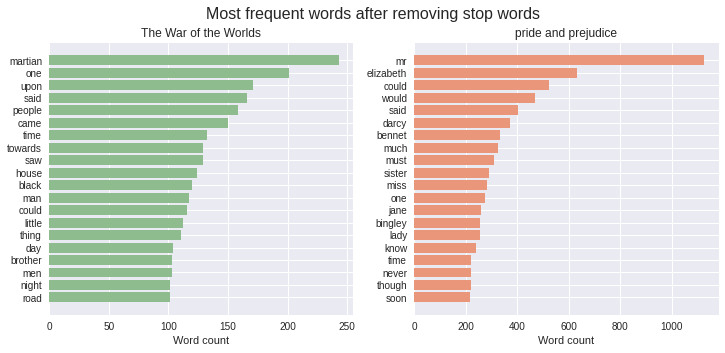

In [15]:
plt.figure(figsize=(12,5))   
plt.style.use('seaborn')    

# The War of the Worlds
plt.subplot(121)
plt.title('The War of the Worlds')
plt.xlabel('Word count')
plt.barh(book1['lemma'],book1['size'],color="darkseagreen")

# pride and prejudice
plt.subplot(122)
plt.title('pride and prejudice')
plt.xlabel('Word count')
plt.barh(book2['lemma'],book2['size'],color="darksalmon")

# 最上面的標題
plt.suptitle('Most frequent words after removing stop words', fontsize=16)

plt.show()

可以看到世界大戰(The War of the Worlds)出現的詞比較不特定，如「people」、「time」、「men」等；傲慢與偏見(pride and prejudice)則比較常出現主要角色的名字或人物稱謂，如「elizabeth」、「jane」、「mr」、「sister」，其他字詞的風格也非常不一樣。

## 3. 將資料分為測試集和訓練集
### 3.1. 根據7:3的比例切分資料集

利用 sklearn 中的 train_test_split 函數將 `raw_data` 隨機切成 7:3，設置 random_state 讓每次切分的結果一致。`y_train`和`y_test`分別為訓練資料和測試資料的預測目標（每個句子所屬的書名id）。

In [16]:
dtf_train, dtf_test = model_selection.train_test_split(raw_data, stratify=raw_data["gutenberg_id"],
                                                       test_size=0.3, random_state=2021)

## get target
y_train = dtf_train["gutenberg_id"].values
y_test = dtf_test["gutenberg_id"].values

看一下各個資料集切分的比例，兩本書應該要一致

In [17]:
print(f"raw data percentage :\n{raw_data['gutenberg_id'].value_counts(normalize=True) * 100}")
print(f"\ntrain percentage :\n{dtf_train['gutenberg_id'].value_counts(normalize=True) * 100}")
print(f"\ntest percentage :\n{dtf_test['gutenberg_id'].value_counts(normalize=True) * 100}")

raw data percentage :
1342    66.322301
36      33.677699
Name: gutenberg_id, dtype: float64

train percentage :
1342    66.319046
36      33.680954
Name: gutenberg_id, dtype: float64

test percentage :
1342    66.329897
36      33.670103
Name: gutenberg_id, dtype: float64


### 4. 將文章轉為 DTM 放入模型訓練

DTM(document term matrix) :
+ 將不同的文章 (document) 以文章中出現過的字詞(term)表示
    + row 是document (文件)
    + column 是字詞 (term)
    + row 內的數字是出現的字數

DTM裡面的值可以有不同的表示方法
+ (1) 依據詞頻 (classic BoW)
    + 用 `CountVectorizer()`
    + unigrams and bigrams
    + [sklearn.feature_extraction.text.CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
+ (2) 依據tfidf (advanced variant of BoW)
    + 篩選出現次數大於10的字
    + 用 `TfidfVectorizer()`
    + [sklearn.feature_extraction.text.TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
+ 常用參數介紹
    + max_features: 取 詞頻 / tfidf 前多少的字
    + min_df: 篩選出現次數大於10的字(可以自行定義要不要篩選，可能會造成準確度下降)
    + ngram_range: unigrams and bigrams

###  4.1 簡單範例介紹DTM

在這裡我們用簡單的三個英文句子，建立一個 DTM，在這裡我們利用 `CountVectorizer` 計算出不同句子的詞頻，再轉換成DTM。DTM裡面每個row代表一個句子，每個column代表一個詞出現的次數。

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
corpus = ['why hello there', 'omg hello hello pony', 'she went there? omg']
vectorizer = CountVectorizer(ngram_range=(1, 2))
X = vectorizer.fit_transform(corpus)
vocabulary = vectorizer.get_feature_names()

# 轉成dataframe來看
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())

print(f"documents: {X.shape[0]} terms: {X.shape[1]}")
print(f"\nterms:\n {vocabulary}") # DTM 字詞可以藉由 get_feature_names 查看
print(f"\nDTM array:\n {X.toarray()}") # DTM的資料結構，裡面代表字詞的頻率
DTM_df

documents: 3 terms: 15

terms:
 ['hello', 'hello hello', 'hello pony', 'hello there', 'omg', 'omg hello', 'pony', 'she', 'she went', 'there', 'there omg', 'went', 'went there', 'why', 'why hello']

DTM array:
 [[1 0 0 1 0 0 0 0 0 1 0 0 0 1 1]
 [2 1 1 0 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 1 1 1 1 1 1 0 0]]


,hello,hello hello,hello pony,hello there,omg,omg hello,pony,she,she went,there,there omg,went,went there,why,why hello
0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,1
1,2,1,1,0,1,1,1,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,1,1,1,1,1,1,0,0


### 4.2 套入正式資料集訓練
在把建模過程寫成function之前，我們先用羅吉斯迴歸(`logistic regression`) 加上詞頻(`cv tokenizer`)示範一次建模的過程

In [19]:
## 定義切分資料的 vectorizer
# Count (classic BoW) 
cv_vectorizer = feature_extraction.text.CountVectorizer(max_features=10000, ngram_range=(1,2)) 
cv_vectorizer_min = feature_extraction.text.CountVectorizer(max_features=10000, ngram_range=(1,2),
                                                            min_df = 10)
# # Tf-Idf (advanced variant of BoW)
# tfidf_vectorizer = feature_extraction.text.TfidfVectorizer(max_features=100, ngram_range=(1,2))

+ 我們建立沒有過濾過詞頻的，和有過濾詞頻的資料集做比較，注意經過轉換之後，X_train的shape會對應到vocabulary的數量

In [20]:
corpus = dtf_train["text"]

# 沒過濾詞頻
cv_vectorizer.fit(corpus)
X_train = cv_vectorizer.transform(corpus)
vocabulary = cv_vectorizer.get_feature_names()

# 詞頻> 10
cv_vectorizer_min.fit(corpus)
X_train_min = cv_vectorizer_min.transform(corpus)
vocabulary_min = cv_vectorizer_min.get_feature_names()

In [21]:
print(f"without term cut off: posts {X_train.shape[0]} words: {X_train.shape[1]} ({len(vocabulary)})") 
print(f"with term cut off: posts {X_train_min.shape[0]} words: {X_train_min.shape[1]} ({len(vocabulary_min)})") 

without term cut off: posts 11315 words: 10000 (10000)
with term cut off: posts 11315 words: 1257 (1257)


定義分類器模型

In [22]:
classifier = LogisticRegression()

定義模型訓練組合，`cv_vectorizer` 加上上面定義的 `LogisticRegression`

In [23]:
## pipeline: 分類器 + 資料處理 vectorizer
model = pipeline.Pipeline([("vectorizer", cv_vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train, y_train)

## test
X_test = dtf_test["text"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

Accuracy: 0.91
Auc: 0.97
Detail:
              precision    recall  f1-score   support

          36       0.92      0.80      0.86      1633
        1342       0.91      0.96      0.93      3217

    accuracy                           0.91      4850
   macro avg       0.91      0.88      0.90      4850
weighted avg       0.91      0.91      0.91      4850



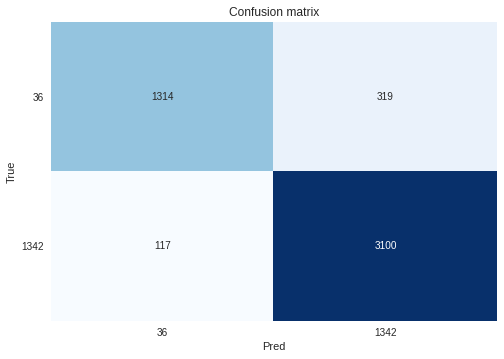

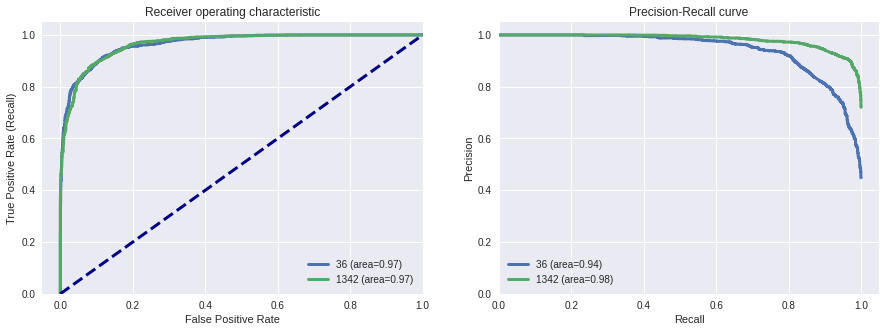

In [24]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test_array, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

In [25]:
## pipeline: 分類器 + 資料處理 vectorizer
model = pipeline.Pipeline([("vectorizer", cv_vectorizer_min),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train_min, y_train)

## test
X_test = dtf_test["text"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

Accuracy: 0.87
Auc: 0.95
Detail:
              precision    recall  f1-score   support

          36       0.85      0.75      0.80      1633
        1342       0.88      0.93      0.91      3217

    accuracy                           0.87      4850
   macro avg       0.87      0.84      0.85      4850
weighted avg       0.87      0.87      0.87      4850



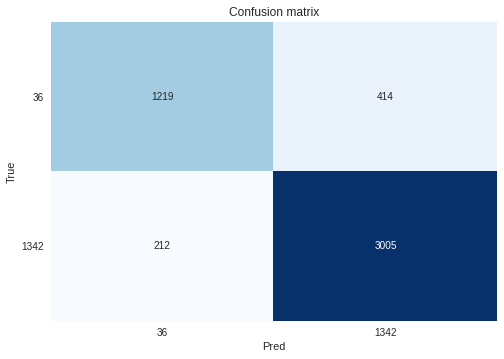

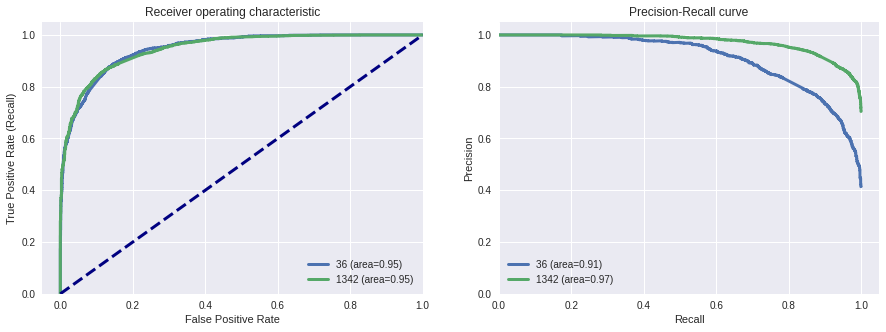

In [26]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test_array, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

可以看到過濾詞頻之後，字詞的維度減少，不過準確度也稍微下降了，同學可以自行嘗試是否依據詞頻過濾，或調整詞頻過濾的大小，看看模型的準確度會有什麼樣的變化

### 4.3. 定義建模與畫圖的函數
因為不同的 classifier 可以和不同的 vectorizer 搭配，為了簡化程式，我們將建模與畫圖的步驟定義成函數

In [27]:
def model_predict(train_data, test_data, train_label, vectorizer, classifier, return_classifier = False):
    
    start = time.time()

    # sentence to DTM
    vectorizer.fit(train_data) # fit(corpus)
    X_train = vectorizer.transform(corpus)    
    
    ## pipeline: 分類器 + 資料處理 vectorizer
    model = pipeline.Pipeline([("vectorizer", vectorizer),  
                               ("classifier", classifier)])
    ## train classifier
    model["classifier"].fit(X_train, train_label)
    
    ## test
    X_test = test_data.values
    predicted = model.predict(X_test)
    predicted_prob = model.predict_proba(X_test)
    
    end = time.time()
    print(f"time costing: {end - start}")
    
    if return_classifier:
        return predicted, predicted_prob, classifier       
    else:
        return predicted, predicted_prob

In [28]:
def evaluate(true, predicted, predicted_prob):

    classes = np.unique(true)
    true_array = pd.get_dummies(true, drop_first=False).values

    ## Accuracy, Precision, Recall
    Accuracy = metrics.accuracy_score(true, predicted)
    AUC = metrics.roc_auc_score(true_array, predicted_prob, 
                                multi_class="ovr")
    
    print("Accuracy:",  round(Accuracy,2))
    print("Auc:", round(AUC,2))
    print("Detail:")
    print(metrics.classification_report(true, predicted))
    
    ## Plot confusion matrix
    cm = metrics.confusion_matrix(true, predicted)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
                cbar=False)
    ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
           yticklabels=classes, title="Confusion matrix")
    plt.yticks(rotation=0)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

    ## Plot roc
    roc_auc_dict = {}
    for i in range(len(classes)):
        fpr, tpr, thresholds = metrics.roc_curve(true_array[:,i],  
                               predicted_prob[:,i])
        roc_auc = metrics.auc(fpr, tpr)
        ax[0].plot(fpr, tpr, lw=3, 
                  label='{0} (area={1:0.2f})'.format(classes[i], roc_auc)
                   )
        roc_auc_dict[classes[i]] = {"fpr":fpr,"tpr": tpr, "roc_auc": roc_auc} 
        
    ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
    ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
              xlabel='False Positive Rate', 
              ylabel="True Positive Rate (Recall)", 
              title="Receiver operating characteristic")
    ax[0].legend(loc="lower right")
    ax[0].grid(True)

    ## Plot precision-recall curve
    for i in range(len(classes)):
        precision, recall, thresholds = metrics.precision_recall_curve(
                     true_array[:,i], predicted_prob[:,i])
        ax[1].plot(recall, precision, lw=3, 
                   label='{0} (area={1:0.2f})'.format(classes[i], 
                                      metrics.auc(recall, precision))
                  )
    ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
              ylabel="Precision", title="Precision-Recall curve")
    ax[1].legend(loc="best")
    ax[1].grid(True)
    plt.show()
    
    return Accuracy, AUC, roc_auc_dict

### step 1 定義 vectorizer

In [29]:
cut_off = 10 # 經由上面的實驗發現在此資料集，詞頻不篩模型會比較準，但需要較長的時間，同學可以自行取捨
vec_cv = feature_extraction.text.CountVectorizer(max_features=10000, ngram_range=(1,2), min_df = cut_off) 
vec_tfidf = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2), min_df = cut_off)

### step 2 定義 classifier

In [30]:
cla_lg = LogisticRegression()
cla_svc = svm.SVC(probability=True)
cla_rf  = ensemble.RandomForestClassifier()

### step 3 定義測試和訓練資料集

In [31]:
train_data = dtf_train["text"]
test_data = dtf_test["text"]
train_label = y_train
test_label = y_test

創造一個空的 dataframe 和 list 存模型結果

In [32]:
result_df = pd.DataFrame(columns=['model_type', 'Accuracy', 'AUC'])
roc_auc_all = {}

## 5.比較不同模型和資料組合的訓練結果

### 5.1 Model Building : logistic regression

model type: CV + logistic regression
time costing: 0.3235812187194824
Accuracy: 0.87
Auc: 0.95
Detail:
              precision    recall  f1-score   support

          36       0.85      0.75      0.80      1633
        1342       0.88      0.93      0.91      3217

    accuracy                           0.87      4850
   macro avg       0.87      0.84      0.85      4850
weighted avg       0.87      0.87      0.87      4850



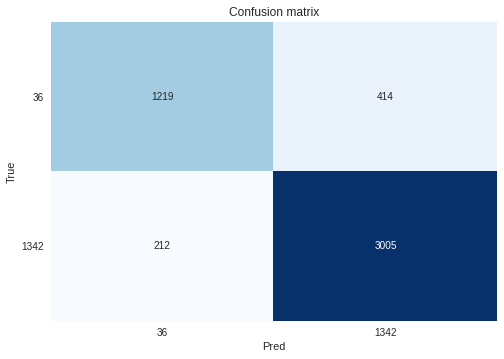

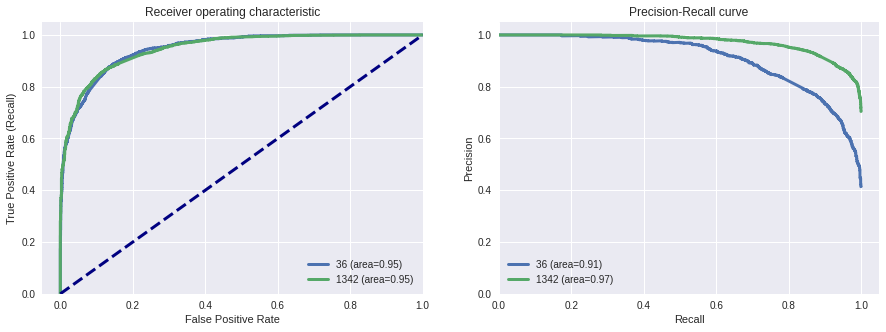

In [33]:
model_type = "CV + logistic regression"
print(f"model type: {model_type}")
# 訓練模型
pred_l , pred_pro_l, logisticRegr = model_predict(train_data, test_data, train_label,
                                 vectorizer = vec_cv, classifier = cla_lg,
                                 return_classifier = True)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred_l, pred_pro_l)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

model type: TF-IDF + logistic regression
time costing: 0.29831671714782715
Accuracy: 0.87
Auc: 0.94
Detail:
              precision    recall  f1-score   support

          36       0.88      0.73      0.80      1633
        1342       0.87      0.95      0.91      3217

    accuracy                           0.87      4850
   macro avg       0.88      0.84      0.85      4850
weighted avg       0.87      0.87      0.87      4850



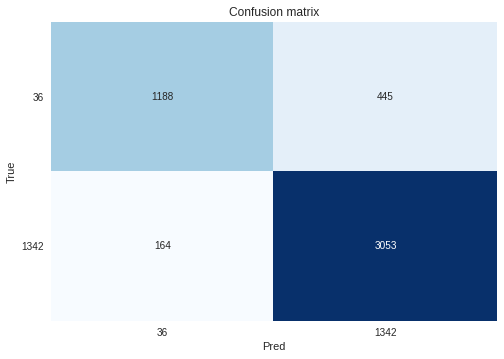

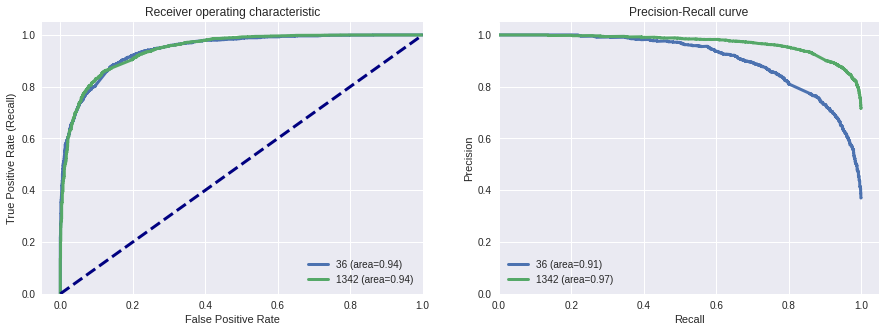

In [34]:
model_type = "TF-IDF + logistic regression"
print(f"model type: {model_type}")

# 訓練模型
pred , pred_pro = model_predict(train_data, test_data, train_label,
                             vectorizer = vec_tfidf , classifier = cla_lg)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

### 5.2 Model Building : SVC
這裡會需要較長的時間

model type: CV + SVC
time costing: 20.08346128463745
Accuracy: 0.87
Auc: 0.94
Detail:
              precision    recall  f1-score   support

          36       0.87      0.73      0.79      1633
        1342       0.87      0.94      0.91      3217

    accuracy                           0.87      4850
   macro avg       0.87      0.84      0.85      4850
weighted avg       0.87      0.87      0.87      4850



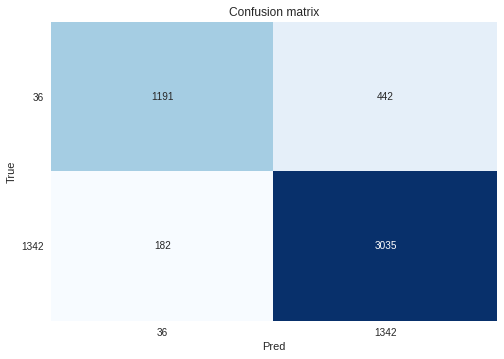

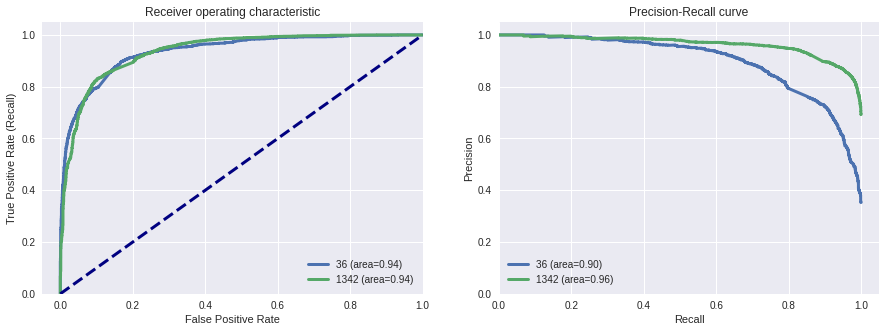

In [35]:
model_type = "CV + SVC"
print(f"model type: {model_type}")
# 訓練模型
pred , pred_pro = model_predict(train_data, test_data, train_label,
                             vectorizer = vec_cv, classifier = cla_svc)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

model type: TF-IDF + SVC
time costing: 19.32533359527588
Accuracy: 0.88
Auc: 0.92
Detail:
              precision    recall  f1-score   support

          36       0.87      0.74      0.80      1633
        1342       0.88      0.94      0.91      3217

    accuracy                           0.88      4850
   macro avg       0.87      0.84      0.85      4850
weighted avg       0.87      0.88      0.87      4850



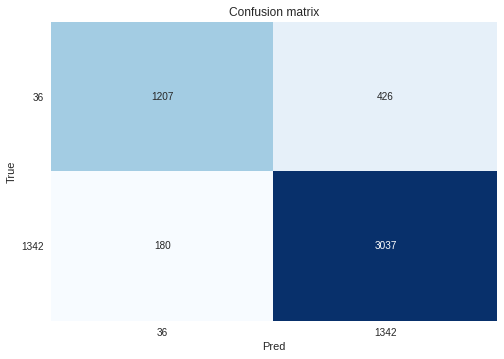

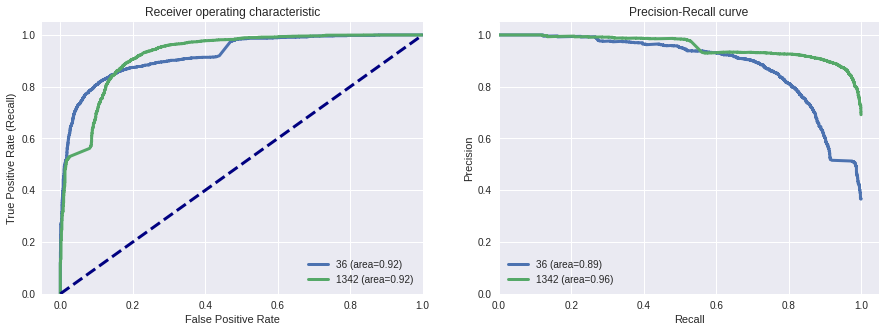

In [36]:
model_type = "TF-IDF + SVC"
print(f"model type: {model_type}")
# 訓練模型
pred , pred_pro = model_predict(train_data, test_data, train_label,
                             vectorizer = vec_tfidf, classifier = cla_svc)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

### 5.3 Model Building : RandomForest

model type: CV + RandomForest
time costing: 3.9814624786376953
Accuracy: 0.83
Auc: 0.91
Detail:
              precision    recall  f1-score   support

          36       0.73      0.77      0.75      1633
        1342       0.88      0.86      0.87      3217

    accuracy                           0.83      4850
   macro avg       0.81      0.81      0.81      4850
weighted avg       0.83      0.83      0.83      4850



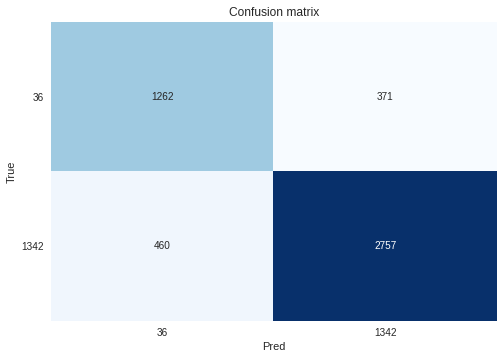

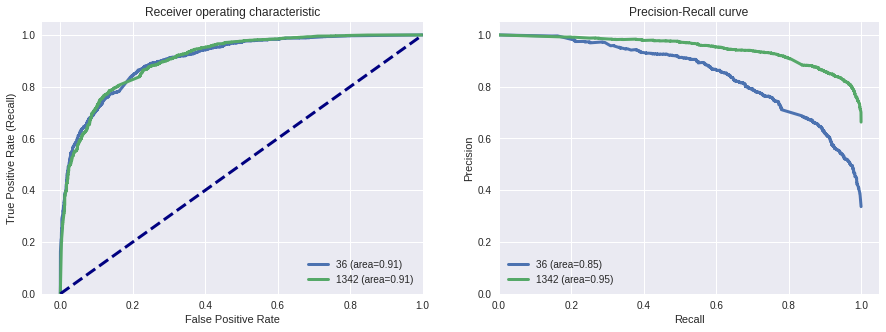

In [37]:
model_type = "CV + RandomForest"
print(f"model type: {model_type}")
# 訓練模型
pred , pred_pro = model_predict(train_data, test_data, train_label,
                             vectorizer = vec_cv, classifier = cla_rf)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

model type: TF-IDF + RandomForest
time costing: 4.800717353820801
Accuracy: 0.85
Auc: 0.92
Detail:
              precision    recall  f1-score   support

          36       0.81      0.74      0.77      1633
        1342       0.87      0.91      0.89      3217

    accuracy                           0.85      4850
   macro avg       0.84      0.82      0.83      4850
weighted avg       0.85      0.85      0.85      4850



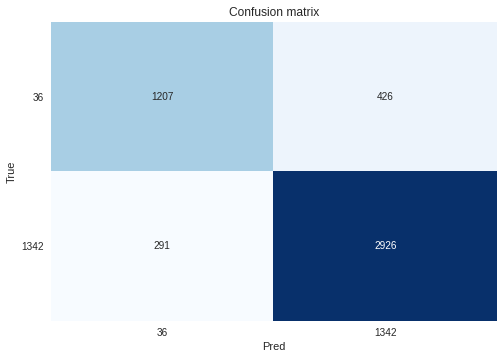

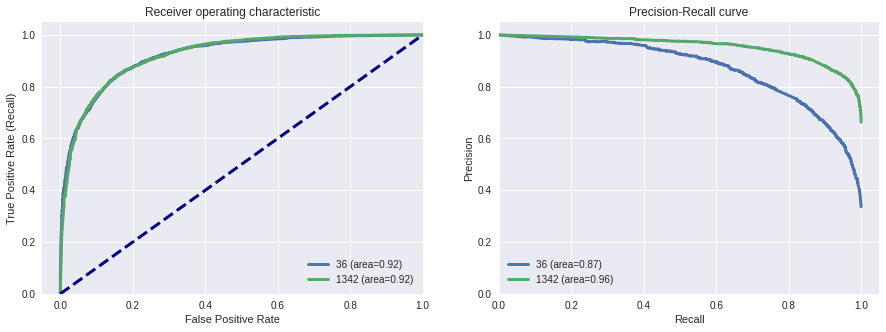

In [38]:
model_type = "TF-IDF + RandomForest"
print(f"model type: {model_type}")
# 訓練模型
pred , pred_pro = model_predict(train_data ,test_data ,train_label,
                             vectorizer = vec_tfidf ,classifier = cla_rf)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

### 5.4 預測結果探索
+ 5.4.1 各字詞特徵的estimate係數
+ 5.4.2 查看分類錯誤的句子
+ 5.4.3 比較不同模型的ROC

In [39]:
result_df.sort_values(by=['Accuracy'], ascending=False)

,model_type,Accuracy,AUC
3,TF-IDF + SVC,0.875052,0.923487
1,TF-IDF + logistic regression,0.874433,0.944018
2,CV + SVC,0.871340,0.936059
0,CV + logistic regression,0.870928,0.946421
5,TF-IDF + RandomForest,0.852165,0.921803
4,CV + RandomForest,0.828660,0.906968


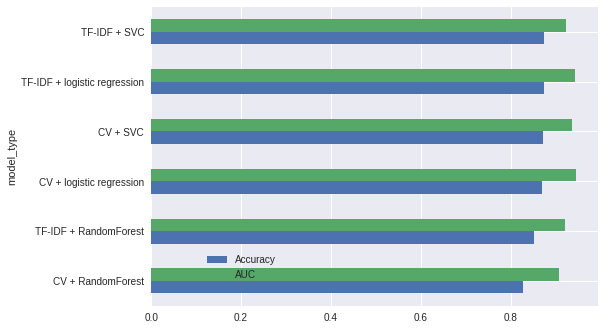

In [40]:
result_df.sort_values(by=['Accuracy'], ascending=True) \
    .plot.barh(x="model_type", y=["Accuracy", "AUC"])
plt.legend(bbox_to_anchor=(0.3,0.2))

### 5.4.1 各字詞特徵的estimate係數
對於線性的模型，可以藉由相關係數，查看資料特徵（詞）對於判斷分類的影響
+ coefficient estimate代表特徵每增加一單位，y是1的發生機率比y是0的發生機率多幾倍（odds ratio 勝算比）
+ 這裡舉 5.1 的 logistic regression + cv tokenizer 為例

In [41]:
def plot_coef(logreg_coef):    
    
    # 選出某個類別的前10大影響力字詞
    for label in logreg_coef.columns:
        top_n = 10
        select_words = logreg_coef[[label]].sort_values(by=label, ascending=False) \
                        .iloc[np.r_[0:top_n, -top_n:0]]    
        word = select_words.index
        count = select_words[label]        
        category_colors = np.where(select_words[label] >= 0, "darkseagreen","rosybrown") # 設定顏色
                
        fig, ax = plt.subplots(figsize =(8, 5)) # 設定畫布
        plt.rcParams['font.sans-serif'] = ['SimHei']  # 設定中文
        
        ax.barh(word, count, color=category_colors)
        ax.invert_yaxis()
        ax.set_title('Coeff increase/decrease odds ratio of 「'+ label +'」 label the most',
                     loc ='left', size = 16)
        ax.set_ylabel('word', size = 14)
        ax.set_xlabel('Word Frequency', size = 14)

In [42]:
# 抓取 CountVectorizer 的字詞
vocabulary = vec_cv.get_feature_names()

# logisticRegr 是 5.1 存起來的模型
log_odds = logisticRegr.coef_[0]
coef_df = pd.DataFrame(log_odds,
             vocabulary, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)
coef_df.head(5)

,coef
elizabeth,5.468591
mr,4.508444
jane,3.472826
darcy,3.465086
mrs,3.094937


/usr/local/anaconda3/envs/test/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/anaconda3/envs/test/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


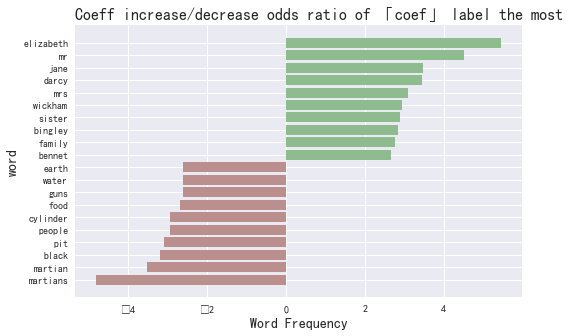

In [43]:
# 把前10大影響力的字詞畫出來
plot_coef(coef_df)

elizabeth,sister,family 等字是影響判斷為傲慢與偏見的重要字；gun,pit,food等字是影響判斷是戰爭與和平(不是傲慢與偏見)的重要字

### 看一下含特定關鍵字的句子

In [44]:
keyword_list = ['food','gun']
original[original['text'].str.contains('|'.join(keyword_list),regex=True)][['gutenberg_id','text']].head(3)

,gutenberg_id,text
35,36,surface must begun course fact scarcely one
94,36,think blaze may casting huge gun
107,36,flaming gases rushed gun


### 5.4.2 查看分類錯誤的句子
這邊用5.1 logistic + cv 的模型當例子

In [45]:
# original # 原本的句子
d = {'true': y_test, 'predict': pred_l}
result = pd.DataFrame(data=d)

# 0: the war of the worlds
# 1: pride and prejudice
# False negative: pride and prejudice(true) => the war of the worlds(prediction)
# False positive: the war of the worlds(true) => pride and prejudice(prediction)
dtf_test['predict'] = pred_l
book1_wrong = dtf_test.loc[(dtf_test['gutenberg_id'] == 36) & (dtf_test['predict'] == 1342)] # False negative
book2_wrong = dtf_test.loc[(dtf_test['gutenberg_id'] == 1342) & (dtf_test['predict'] == 36)] # False positive

print(f"False negative:{book1_wrong.shape}")
print(f"False positive:{book2_wrong.shape}")

False negative:(414, 6)
False positive:(212, 6)


/usr/local/anaconda3/envs/test/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [46]:
# False negative
book1_wrong[['text','document','gutenberg_id','predict']].head(5)

,text,document,gutenberg_id,predict
552,sunset faded twilight anything happened,668,36,1342
3965,gesticulating moment shared panic gesture,4738,36,1342
4193,crawl drink craved eleventh day,5006,36,1342
182,earthward rushing pace many miles second,214,36,1342
102,twelfth spectroscope resorted,124,36,1342


In [47]:
# False positive:
book2_wrong[['text','document','gutenberg_id','predict']].head(5)

,text,document,gutenberg_id,predict
9973,one,12021,1342,36
15665,case,18893,1342,36
12327,brought time descent among hanging woods,14840,1342,36
11027,near relationship constant intimacy still one,13281,1342,36
12254,suddenly came forward road led behind stables,14760,1342,36


### 5.4.3 比較不同模型的ROC

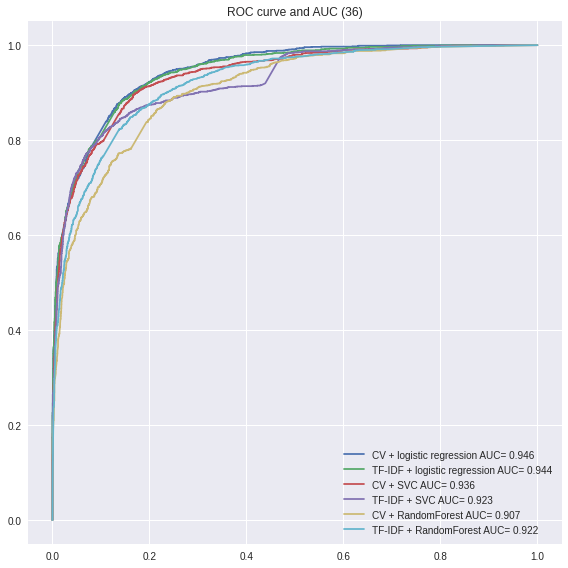

In [48]:
plt.style.use('seaborn')    

l = [36]
for label in l:
    plt.figure(figsize =(8, 8))
    for k, v in roc_auc_all.items():
        fpr = roc_auc_all[k][label]["fpr"]
        tpr = roc_auc_all[k][label]["tpr"]
        roc_auc = roc_auc_all[k][label]["roc_auc"]
        plt.plot(fpr,tpr,label= k + " AUC= %0.3f" % roc_auc)
        plt.title('ROC curve and AUC ('+ str(label) +')')    
    plt.legend(loc=0)
    plt.tight_layout() # 讓圖片對齊

accuracy可能會因為正負面資料分布不同而有所偏差，所以選擇模型的時候，可以加入一起 AUC 評估。在這裡可以看到雖然 SVC+TF-IDF的準確度是最高的，但以AUC來看，CV + logistic的 AUC 反而表現較好。

## 結論
1. 兩本小說的字詞分部有甚麼不同，代表字詞有哪些？
    + 初步用詞頻探索發現，世界大戰(The War of the Worlds)出現的詞多為普通用字，如「people」、「time」、「men」等；傲慢與偏見(pride and prejudice)則比較常出現主要角色的名字或人物稱謂，如「elizabeth」、「jane」、「mr」、「sister」，其他字詞的風格也非常不一樣。建模後觀察elizabeth,sister,family 等字是影響判斷為傲慢與偏見的重要字；gun,pit,food等字是影響判斷是戰爭與和平(不是傲慢與偏見)的重要字
2. 如果用詞頻建立DTM，需不需要篩選詞頻？
    + 經由 4.2 的實驗發現，不篩詞頻模型會比較準，但需要較長的時間，同學可以自行取捨
3. 此資料集用什麼樣的模型預測，準確率會較高？
    + SVC+TF-IDF的準確度是最高的，但以AUC來看，CV + logistic的 AUC 反而表現較好。

### 參考資料

+ DTM
    + https://theslaps.medium.com/constructing-a-document-term-matrix-via-sklearn-nltk-65de053d9e91
+ Logistic Regression using Python (scikit-learn)
    + https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a
+ Advantages of AUC vs standard accuracy
    + https://datascience.stackexchange.com/questions/806/advantages-of-auc-vs-standard-accuracy